In [12]:
import zipfile
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


# 从zip文件中读取人脸图像并缩放到32x32像素
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue  # 不是人脸图像
        with facezip.open(filename) as image:
            # 读取图像
            img = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
            # 缩放图像到32x32像素
            resized_img = cv2.resize(img, (32, 32))
            faces[filename] = resized_img

'''
# 从attface文件夹及其子文件夹中读取人脸图像
faces = {}
data_directory = "attface"  # attface文件夹路径

for root, dirs, files in os.walk(data_directory):
    for filename in files:
        if filename.endswith(".pgm"):
            file_path = os.path.join(root, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            faces[filename] = img
'''

'\n# 从attface文件夹及其子文件夹中读取人脸图像\nfaces = {}\ndata_directory = "attface"  # attface文件夹路径\n\nfor root, dirs, files in os.walk(data_directory):\n    for filename in files:\n        if filename.endswith(".pgm"):\n            file_path = os.path.join(root, filename)\n            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)\n            faces[filename] = img\n'

显示示例人脸图像


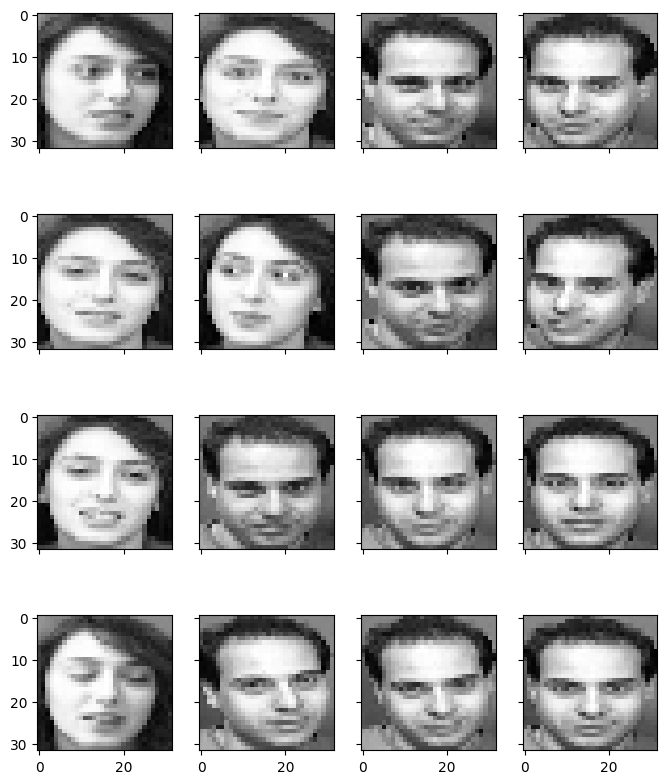

人脸图像形状: (32, 32)
类别数量: 40
图像数量: 400


In [13]:

# 使用matplotlib显示示例人脸图像
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
faceimages = list(faces.values())[-16:] # 取最后16张图像
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("显示示例人脸图像")
plt.show()

# 打印一些细节
faceshape = list(faces.values())[0].shape
print("人脸图像形状:", faceshape)

# 从文件名中提取类别
classes = set(filename.split("/")[0] for filename in faces.keys())

print("类别数量:", len(classes))
print("图像数量:", len(faces))

In [14]:
# PCA实现函数
def pca(X, n_components):
    # 计算数据矩阵的均值
    mean = np.mean(X, axis=0)
    # 中心化数据矩阵
    X_centered = X - mean
    # 计算数据矩阵的协方差矩阵
    covariance_matrix = np.cov(X_centered, rowvar=False)
    # 计算协方差矩阵的特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # 对特征向量按特征值从大到小排序
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # 选取前n_components个特征向量
    principal_components = sorted_eigenvectors[:, :n_components]
    # 返回投影矩阵和均值向量
    return principal_components, mean


特征脸形状: (1024, 50)
均值脸形状: (1024,)
权重矩阵形状: (50, 388)
显示特征脸


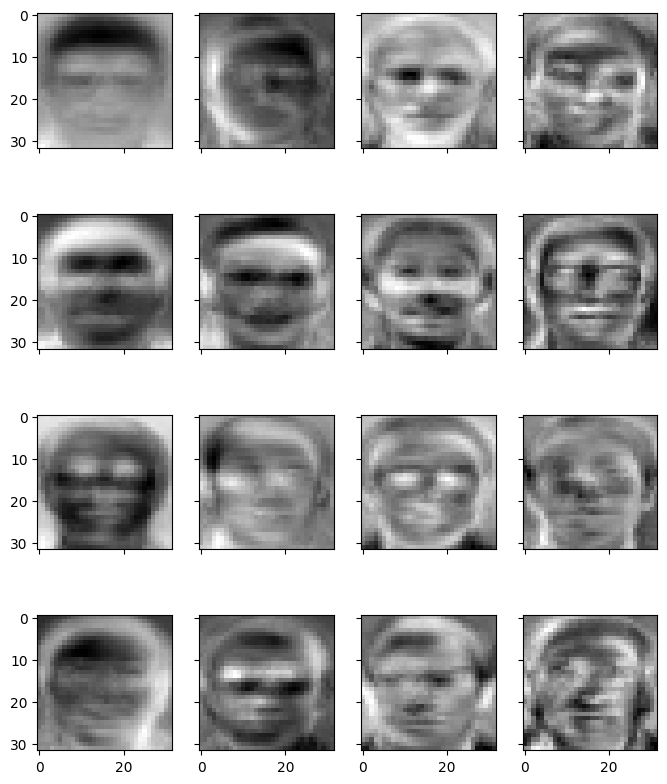

In [15]:
# 为特征脸构建数据矩阵和标签向量
facematrix = []
facelabel = []
for key, val in faces.items():
    if key.startswith("s40/"):
        continue # 这是我们的测试集
    if key == "s39/10.pgm":
        continue # 这是我们的测试集
    if key == "s8/2.pgm":
        continue # 这是我们的测试集
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

# 创建一个NxM矩阵，其中N为图像数量，M为每个图像的像素数
facematrix = np.array(facematrix)

# 应用PCA并选择前K个主成分作为特征脸
n_components = 50
eigenfaces, mean_face = pca(facematrix, n_components)
print("特征脸形状:", eigenfaces.shape)
print("均值脸形状:", mean_face.shape)

# 生成权重矩阵，其中K为特征脸数量，N为样本数量
weights = eigenfaces.T @ (facematrix - mean_face).T
print("权重矩阵形状:", weights.shape)

# 显示前16个特征脸
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
print("显示特征脸")
plt.show()

查询图像形状: (1, 1024)
查询图像的权重向量形状: (50, 1)
最佳匹配 s39，欧几里得距离 482.901047


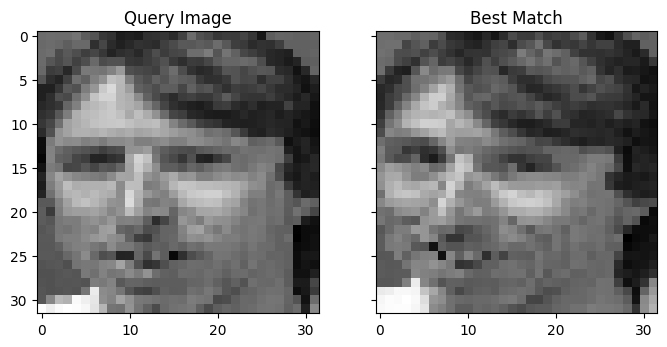

In [16]:
# 测试已存在类别的样本图像
query = faces["s39/10.pgm"].reshape(1,-1)
print("查询图像形状:", query.shape)

# 计算查询图像的权重向量
query_weight = eigenfaces.T @ (query.flatten() - mean_face).reshape(-1, 1)
print("查询图像的权重向量形状:", query_weight.shape)

euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("最佳匹配 %s，欧几里得距离 %f" % (facelabel[best_match], euclidean_distance[best_match]))
# 可视化
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query Image")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best Match")
plt.show()

最佳匹配 s8，欧几里得距离 345.383411


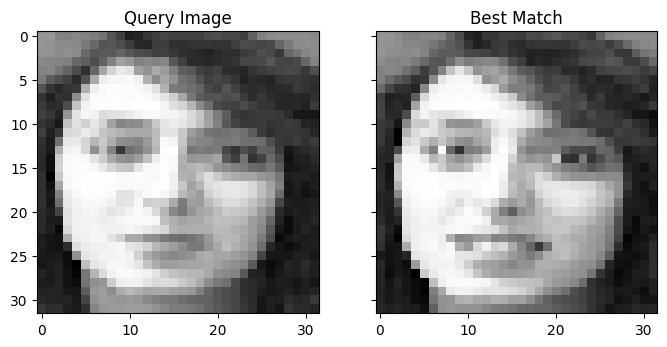

In [17]:
# 测试已存在类别的样本图像
query = faces["s8/2.pgm"].reshape(1,-1)
# 计算查询图像的权重向量
query_weight = eigenfaces.T @ (query.flatten() - mean_face).reshape(-1, 1)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("最佳匹配 %s，欧几里得距离 %f" % (facelabel[best_match], euclidean_distance[best_match]))
# 可视化
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query Image")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best Match")
plt.show()

最佳匹配 s5，欧几里得距离 836.529860


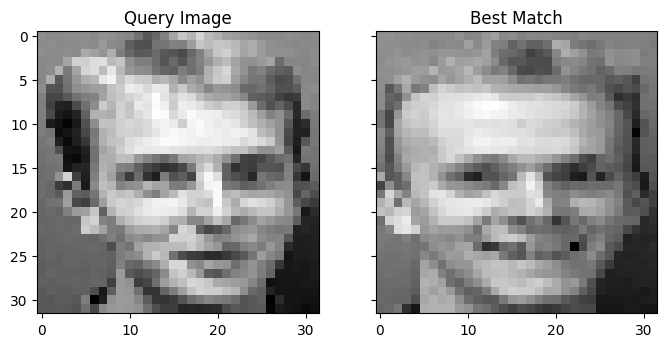

In [18]:
# 测试新类别的样本图像
query = faces["s40/1.pgm"].reshape(1,-1)
# 计算查询图像的权重向量
query_weight = eigenfaces.T @ (query.flatten() - mean_face).reshape(-1, 1)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("最佳匹配 %s，欧几里得距离 %f" % (facelabel[best_match], euclidean_distance[best_match]))
# 可视化
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query Image")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best Match")
plt.show()

Showing sample faces


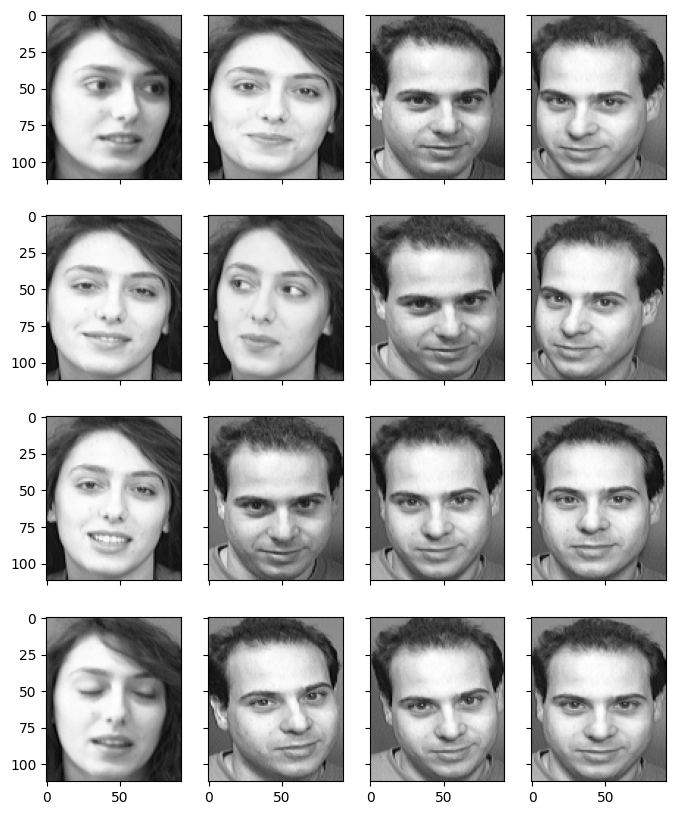

Face image shape: (112, 92)
Number of classes: 40
Number of images: 400
Shape of the face matrix: (389, 10304)
Shape of the eigenfaces: (50, 10304)
Showing the eigenfaces


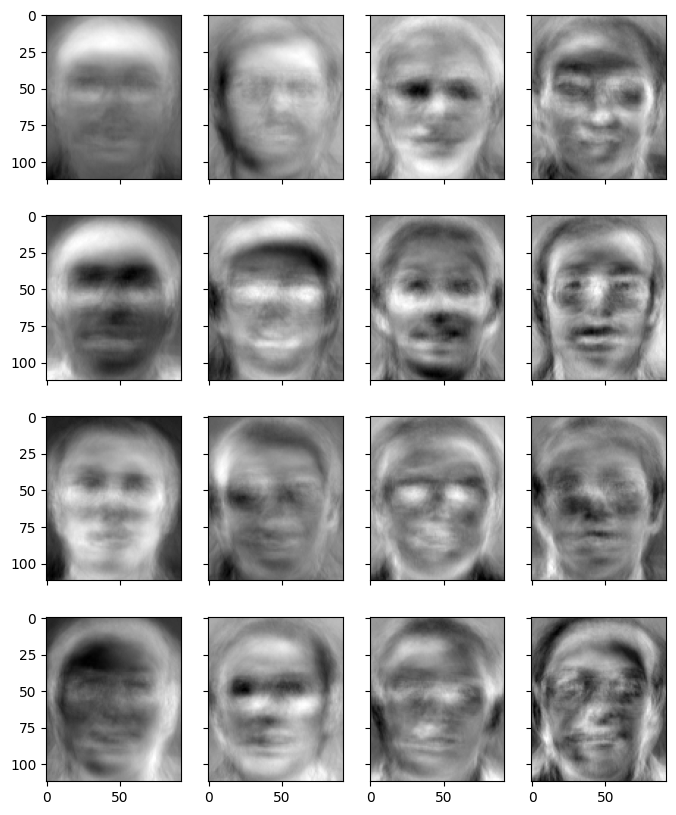

Shape of the weight matrix: (50, 389)
Best match s39 with Euclidean distance 1559.997137


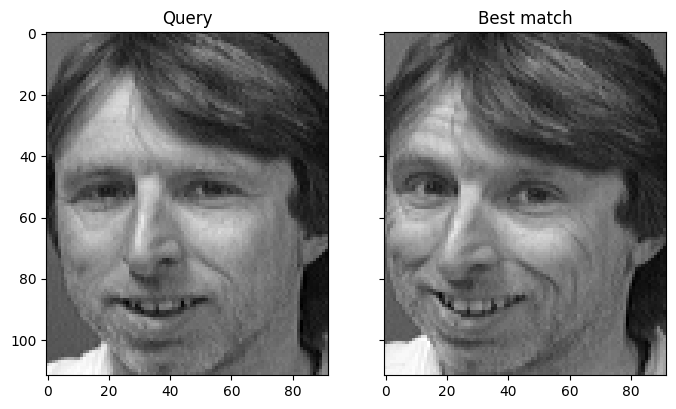

Best match s5 with Euclidean distance 2690.209330


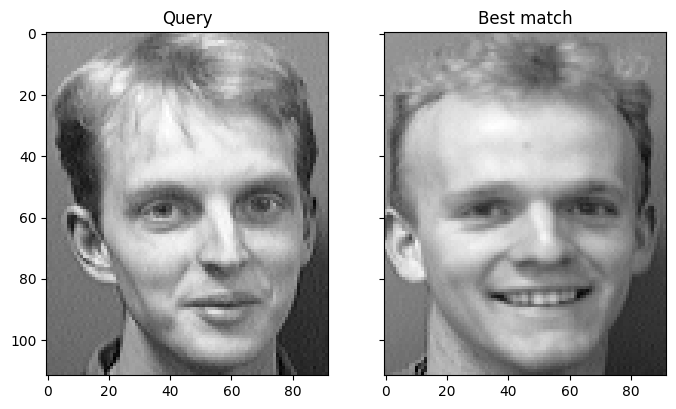

In [19]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Read face image from zip file on the fly
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

# Show sample faces using matplotlib
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

# Print some details
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

# Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)
print("Shape of the face matrix:", facematrix.shape)

# Apply PCA and take first K principal components as eigenfaces
pca = PCA().fit(facematrix)

n_components = 50
eigenfaces = pca.components_[:n_components]
print("Shape of the eigenfaces:", eigenfaces.shape)

# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the eigenfaces")
plt.show()

# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

# Test on out-of-sample image of new class
query = faces["s40/1.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()